In [1]:
library(ArchR)
library(Seurat)
library(dplyr)
library(tidyr)
library(parallel)


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 

In [2]:
projdir <- '/nas/homes/benyang/HiC/13_MultiOme/ArchR_analysis'

addArchRGenome("mm10")
addArchRThreads(threads = 45) 

projAging3 <- readRDS(file.path(projdir, "Save-projAging3-01", "Save-ArchR-Project.rds"))

Setting default genome to Mm10.

Setting default number of Parallel threads to 45.



In [3]:
scRNA <- readRDS("/nas/homes/benyang/HiC/13_MultiOme/TabulaMurisSenis/aging_RNA_integrated_annotated.RDS")

In [4]:
source(file.path(projdir, 'ArchR_utilities.R'))

Loading required package: MASS


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: mclust

Package 'mclust' version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.

Loading required package: ChIPseeker



ChIPseeker v1.32.1  For help: https://guangchuangyu.github.io/software/ChIPseeker

If you use ChIPseeker in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Qing-Yu He. ChIPseeker: an R/Bioconductor package for ChIP peak annotation, comparison and visualization. Bioinformatics 2015, 31(14):2382-2383


Attaching package: ‘ChIPseeker’


The following object is masked from ‘package:plyr’:

    .


Loading required package: TxDb.Mmusculus.UCSC.mm10.knownGene

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi


Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:MASS’:

    select


The following object is masked from 

In [10]:
projAging3


           ___      .______        ______  __    __  .______      
          /   \     |   _  \      /      ||  |  |  | |   _  \     
         /  ^  \    |  |_)  |    |  ,----'|  |__|  | |  |_)  |    
        /  /_\  \   |      /     |  |     |   __   | |      /     
       /  _____  \  |  |\  \\___ |  `----.|  |  |  | |  |\  \\___.
      /__/     \__\ | _| `._____| \______||__|  |__| | _| `._____|
    



class: ArchRProject 
outputDirectory: /nas/homes/benyang/HiC/13_MultiOme/ArchR_analysis/output 
samples(4): Aged_v2 Young_v2 Aged Young
sampleColData names(1): ArrowFiles
cellColData names(23): Sample TSSEnrichment ...
  Harmony_Age_Clusters_res0.3 New_Harmony_4iter_Clusters_res0.2
numberOfCells(1): 24930
medianTSS(1): 21.8735
medianFrags(1): 7824

# Unconstrained integration

In [11]:
projAging4 <- addGeneIntegrationMatrix(
    ArchRProj = projAging3, 
    useMatrix = "GeneScoreMatrix",
    matrixName = "Harmony_4iter_GeneIntegrationMatrix",
    reducedDims = "Harmony_4iter",
    seRNA = scRNA,
    addToArrow = FALSE,
    groupRNA = "celltype",
    nameCell = "Harmony_4iter_predictedCell_Un",
    nameGroup = "Harmony_4iter_predictedGroup_Un",
    nameScore = "Harmony_4iter_predictedScore_Un"
)

ArchR logging to : ArchRLogs/ArchR-addGeneIntegrationMatrix-be4b1e611e-Date-2022-12-23_Time-03-57-21.log
If there is an issue, please report to github with logFile!

2022-12-23 03:57:21 : Running Seurat's Integration Stuart* et al 2019, 0.005 mins elapsed.

2022-12-23 03:57:21 : Checking ATAC Input, 0.008 mins elapsed.

2022-12-23 03:57:27 : Checking RNA Input, 0.104 mins elapsed.

2022-12-23 03:57:32 : Found 22699 overlapping gene names from gene scores and rna matrix!, 0.182 mins elapsed.

2022-12-23 03:57:32 : Creating Integration Blocks, 0.182 mins elapsed.

2022-12-23 03:57:32 : Prepping Interation Data, 0.191 mins elapsed.

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

2022-12-23 03:57:33 : Computing Integration in 3 Integration Blocks!, 0 mins elapsed.

2022-12-23 04:05:53 : Block (1 of 3) : Plotting Joint UMAP, 8.33 mins elapsed.

2022-12-23 04:06:27 : Block (2 of 3) : Plotting Joint UMAP, 8.9 mins elapsed.

2022-12-23 04:07:00 : Block (3 of 3) : Plotting Joint UMAP, 

## First, we will identify which cell types from the scRNA-seq data are most abundant in each of our scATAC-seq clusters.

In [12]:
cM <- as.matrix(confusionMatrix(projAging4$New_Harmony_4iter_Clusters_res0.2, projAging4$Harmony_4iter_predictedGroup_Un))
preClust <- colnames(cM)[apply(cM, 1 , which.max)]
preClust_assignments = cbind(preClust, rownames(cM)) #Assignments

preClust_assignments
#unique(unique(projAging4$predictedGroup_Un))

preClust,
NK Cell,C6
Endothelial,C3
Macrophage,C8.1
T Cell,C7
B Cell,C9
MSC,C1.1
T Cell,C8.2
MuSC,C4
Smooth Muscle,C2
Tenocyte,C1.2


# Constrained integration

## Assign clusters to cell types

In [67]:
defined_celltype_clusters <- data.frame(celltype = c("MuSC", "Endothelial", "Smooth Muscle", "Schwann Cell", "Macrophage"),
                                        cluster = c("C4", "C3", "C2", "C5", "C8.1|C8.2"))
defined_celltype_clusters$pattern <- sapply(defined_celltype_clusters$cluster, function(x) {
    x <- paste0("\\b",x,"\\b")
    x <- gsub('|',"\\b|\\b",x,fixed=TRUE)
    })

In [68]:
defined_celltype_clusters

celltype,cluster,pattern
<chr>,<chr>,<chr>
MuSC,C4,\bC4\b
Endothelial,C3,\bC3\b
Smooth Muscle,C2,\bC2\b
Schwann Cell,C5,\bC5\b
Macrophage,C8.1|C8.2,\bC8.1\b|\bC8.2\b


In [69]:
defined_clusters <- paste(sapply(unlist(strsplit(paste(defined_celltype_clusters$cluster, collapse="|"), split='|', fixed=T)), function(x) paste0('\\b', x, '\\b')), collapse='|')
defined_clusters

[1] "\\bC4\\b|\\bC3\\b|\\bC2\\b|\\bC5\\b|\\bC8.1\\b|\\bC8.2\\b"

## Make lists of cellnames 

In [70]:
atac_cellnames <- lapply(defined_celltype_clusters$pattern, function(i) projAging4$cellNames[grepl(pattern = i, x = projAging4$New_Harmony_4iter_Clusters_res0.2)])
names(atac_cellnames) <- defined_celltype_clusters$celltype

rna_cellnames <- lapply(defined_celltype_clusters$celltype, function(i) Cells(scRNA)[scRNA$celltype %in% i])
names(rna_cellnames) <- defined_celltype_clusters$celltype
                         
atac_non_cellnames <- projAging4$cellNames[!grepl(defined_clusters, projAging4$New_Harmony_4iter_Clusters_res0.2)]
rna_non_cellnames <- Cells(scRNA)[!scRNA$celltype %in% unique(defined_celltype_clusters$celltype)]

In [71]:
str(atac_cellnames)

List of 5
 $ MuSC         : chr [1:997] "Aged_v2#CTAATCCGTTAAGGTT-1" "Aged_v2#GTGCTTCTCTTGCTAT-1" "Aged_v2#GTGATCAGTGTAACCA-1" "Aged_v2#TCCGGTTTCTTTGAGA-1" ...
 $ Endothelial  : chr [1:4301] "Aged_v2#ATGTTTGAGCGATACT-1" "Aged_v2#GAGCGATAGGATAAAC-1" "Aged_v2#TGATCAATCCTCACTA-1" "Aged_v2#TAATGCATCCCGCCTA-1" ...
 $ Smooth Muscle: chr [1:2310] "Aged_v2#GGCTATGTCATGCTTT-1" "Aged_v2#GACGCAACACAAACTT-1" "Aged_v2#CCAACATAGGTAACGA-1" "Aged_v2#GTACTTCGTATTGCAG-1" ...
 $ Schwann Cell : chr [1:3823] "Aged_v2#TTGGCTGAGTTGTCTT-1" "Aged_v2#CGTAATGGTGATCAGC-1" "Aged_v2#CCGGTAGGTGGATTGC-1" "Aged_v2#AGCGGATAGCTTCCCG-1" ...
 $ Macrophage   : chr [1:1658] "Aged_v2#TCTTAGTTCTCCATGC-1" "Aged_v2#CTAACCCTCAAGCGCC-1" "Aged_v2#AGATGCTTCTAGCGTG-1" "Aged_v2#CGGATTAGTTTGAGGC-1" ...


In [72]:
groupList <- SimpleList(
    MuSC = SimpleList(
        ATAC = atac_cellnames[['MuSC']],
        RNA = rna_cellnames[['MuSC']]
    ),
    Endothelial = SimpleList(
        ATAC = atac_cellnames[['Endothelial']],
        RNA = rna_cellnames[['Endothelial']]
    ),
    SmoothMuscle = SimpleList(
        ATAC = atac_cellnames[['Smooth Muscle']],
        RNA = rna_cellnames[['Smooth Muscle']]
    ),
    Macrophage = SimpleList(
        ATAC = atac_cellnames[['Macrophage']],
        RNA = rna_cellnames[['Macrophage']]
    ),
    Schwann = SimpleList(
        ATAC = atac_cellnames[['Schwann Cell']],
        RNA = rna_cellnames[['Schwann Cell']]
    ),
    NonTarget = SimpleList(
        ATAC = atac_non_cellnames,
        RNA = rna_non_cellnames
    )
)

## Constrained integration

In [73]:
projAging4 <- addGeneIntegrationMatrix(
    ArchRProj = projAging4, 
    useMatrix = "GeneScoreMatrix",
    matrixName = "Harmony_4iter_GeneIntegrationMatrix",
    reducedDims = "Harmony_4iter",
    seRNA = scRNA,
    addToArrow = FALSE, 
    groupList = groupList,
    groupRNA = "celltype",
    nameCell = "Harmony_4iter_predictedCell_Co",
    nameGroup = "Harmony_4iter_predictedGroup_Co",
    nameScore = "Harmony_4iter_predictedScore_Co"
)


ArchR logging to : ArchRLogs/ArchR-addGeneIntegrationMatrix-be4b68bbd581-Date-2022-12-23_Time-05-43-43.log
If there is an issue, please report to github with logFile!

2022-12-23 05:43:43 : Running Seurat's Integration Stuart* et al 2019, 0.005 mins elapsed.

2022-12-23 05:43:44 : Checking ATAC Input, 0.009 mins elapsed.

2022-12-23 05:43:46 : Checking RNA Input, 0.055 mins elapsed.

2022-12-23 05:43:51 : Found 22699 overlapping gene names from gene scores and rna matrix!, 0.135 mins elapsed.

2022-12-23 05:43:51 : Creating Integration Blocks, 0.135 mins elapsed.

2022-12-23 05:43:51 : Prepping Interation Data, 0.138 mins elapsed.

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

2022-12-23 05:43:52 : Computing Integration in 6 Integration Blocks!, 0 mins elapsed.

2022-12-23 05:52:42 : Block (1 of 6) : Plotting Joint UMAP, 8.825 mins elapsed.

2022-12-23 05:53:07 : Block (2 of 6) : Plotting Joint UMAP, 9.241 mins elapsed.

2022-12-23 05:53:27 : Block (3 of 6) : Plotting Joint U

In [74]:
plt_list <- lapply(c('New_Harmony_4iter_Clusters_res0.2','Harmony_4iter_predictedGroup_Un', 'Harmony_4iter_predictedGroup_Co'), 
                   function(x) plotEmbedding(projAging4, embedding="UMAP_Harmony_4iter", colorBy="cellColData", name=x))
plotPDF(plotList = plt_list, 
        name = "Plot-UMAP-RNA-Integration.pdf", 
        ArchRProj = projAging4, 
        addDOC = FALSE, width = 4, height = 4)

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-be4b410921b3-Date-2022-12-23_Time-05-54-39.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-be4b410921b3-Date-2022-12-23_Time-05-54-39.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-be4b254136e3-Date-2022-12-23_Time-05-54-43.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-be4b254136e3-Date-2022-12-23_Time-05-54-43.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-be4b1f3bc06d-Date-2022-12-23_Time-05-54-44.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-be4b1f3bc06d-Date-2022-12-23_Time-05-

## Store integration matrix in object

In [75]:
projAging4 <- addGeneIntegrationMatrix(
    ArchRProj = projAging4, 
    useMatrix = "GeneScoreMatrix",
    matrixName = "Harmony_4iter_GeneIntegrationMatrix",
    reducedDims = "Harmony_4iter",
    seRNA = scRNA,
    addToArrow = TRUE, 
    groupList = groupList,
    groupRNA = "celltype",
    nameCell = "Harmony_4iter_predictedCell_Co",
    nameGroup = "Harmony_4iter_predictedGroup_Co",
    nameScore = "Harmony_4iter_predictedScore_Co",
    force = TRUE
)


ArchR logging to : ArchRLogs/ArchR-addGeneIntegrationMatrix-be4b4f513225-Date-2022-12-23_Time-05-56-30.log
If there is an issue, please report to github with logFile!

2022-12-23 05:56:30 : Running Seurat's Integration Stuart* et al 2019, 0.004 mins elapsed.

2022-12-23 05:56:30 : Checking ATAC Input, 0.007 mins elapsed.

2022-12-23 05:56:33 : Checking RNA Input, 0.056 mins elapsed.

2022-12-23 05:56:38 : Found 22699 overlapping gene names from gene scores and rna matrix!, 0.134 mins elapsed.

2022-12-23 05:56:38 : Creating Integration Blocks, 0.134 mins elapsed.

2022-12-23 05:56:38 : Prepping Interation Data, 0.136 mins elapsed.

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

2022-12-23 05:56:39 : Computing Integration in 6 Integration Blocks!, 0 mins elapsed.

2022-12-23 06:06:35 : Block (1 of 6) : Plotting Joint UMAP, 9.944 mins elapsed.

2022-12-23 06:07:00 : Block (2 of 6) : Plotting Joint UMAP, 10.361 mins elapsed.

2022-12-23 06:07:21 : Block (3 of 6) : Plotting Joint 

In [110]:
table(projAging4$Harmony_4iter_predictedGroup_Co)


         B Cell     Endothelial      Macrophage             MSC            MuSC 
           2591            4301            1658            4713             997 
        NK Cell    Schwann Cell Skeletal Muscle   Smooth Muscle          T Cell 
           1940            3823             472            2310            1192 
       Tenocyte 
            933 

## Merge skeletal muscle cells with the MSC cluster

In [122]:
projAging4$celltype <- projAging4$Harmony_4iter_predictedGroup_Co
projAging4$celltype[projAging4$celltype=='Skeletal Muscle'] <- 'MSC'

In [124]:
table(projAging4$Harmony_4iter_predictedGroup_Co, projAging4$celltype)

                 
                  B Cell Endothelial Macrophage  MSC MuSC NK Cell Schwann Cell
  B Cell            2591           0          0    0    0       0            0
  Endothelial          0        4301          0    0    0       0            0
  Macrophage           0           0       1658    0    0       0            0
  MSC                  0           0          0 4713    0       0            0
  MuSC                 0           0          0    0  997       0            0
  NK Cell              0           0          0    0    0    1940            0
  Schwann Cell         0           0          0    0    0       0         3823
  Skeletal Muscle      0           0          0  472    0       0            0
  Smooth Muscle        0           0          0    0    0       0            0
  T Cell               0           0          0    0    0       0            0
  Tenocyte             0           0          0    0    0       0            0
                 
                

# Make bubble plots for gene activity and gene expression

## Calculate marker genes for cell types 

In [125]:
markersGS <- getMarkerFeatures(
    ArchRProj = projAging4, 
    useMatrix = "GeneScoreMatrix", 
    groupBy = "celltype",
    bias = c("TSSEnrichment", "log10(nFrags)"),
    testMethod = "wilcoxon"
)

ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-be4b4eadbdbf-Date-2022-12-23_Time-06-56-26.log
If there is an issue, please report to github with logFile!

MatrixClass = Sparse.Double.Matrix

2022-12-23 06:56:27 : Matching Known Biases, 0.003 mins elapsed.

###########
2022-12-23 07:00:23 : Completed Pairwise Tests, 3.943 mins elapsed.
###########

ArchR logging successful to : ArchRLogs/ArchR-getMarkerFeatures-be4b4eadbdbf-Date-2022-12-23_Time-06-56-26.log



In [126]:
markerList <- getMarkers(markersGS, cutOff = "FDR <= 0.01 & Log2FC >= 1.25")
markerListDF <- do.call(rbind, lapply(1:length(markerList), function(x) cbind(markerList[[x]], cluster = names(markerList[x]))))

In [127]:
as.data.frame(markerListDF) %>% group_by(cluster) %>% slice(1:5)

seqnames,start,end,strand,name,idx,Log2FC,FDR,MeanDiff,cluster
<chr>,<int>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>
chr17,34226175,34588543,1,Notch4,555,1.974549,4.966332e-86,5.0396836,B Cell
chr17,34264832,34316674,1,H2-Eb1,558,2.897136,5.328063e-83,3.4893409,B Cell
chr17,34287771,34282751,2,H2-Aa,559,3.095674,6.739712e-83,3.5931374,B Cell
chr15,82224339,82221744,2,Tnfrsf13c,540,3.476168,3.309043e-81,3.1038296,B Cell
chr17,34325675,34341410,1,H2-Eb2,560,3.037537,1.249548e-80,1.4715724,B Cell
chr5,147725988,147562196,2,Flt1,1346,2.989802,9.621960e-83,2.2116868,Endothelial
chr2,181671640,181669837,2,Sox18,2037,3.980174,7.198085e-67,3.1804990,Endothelial
chr2,119325784,119335666,1,Dll4,1237,2.759772,5.232161e-65,2.0710101,Endothelial
chr6,31563937,31519493,2,Podxl,163,2.821905,5.540409e-61,1.2401797,Endothelial


In [133]:
as.data.frame(markerListDF[markerListDF$cluster=="Macrophage", ])

,seqnames,start,end,strand,name,idx,Log2FC,FDR,MeanDiff,cluster
,<chr>,<int>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<chr>
4129,chr11,114890041,114904651,1,Cd300a,1624,3.201016,1.944146e-86,1.7244599,Macrophage
15460,chr4,132564067,132582683,1,Ptafr,1021,2.676326,1.998405e-76,1.1590307,Macrophage
3542,chr11,83582061,83623693,1,E230016K23Rik,1037,3.608960,3.339022e-75,0.8046393,Macrophage
3544,chr11,83649378,83647843,2,Ccl3,1039,3.015589,1.374573e-71,1.4990828,Macrophage
9565,chr17,48232739,48246924,1,Trem1,893,4.257858,2.542443e-70,0.8902218,Macrophage
3543,chr11,83593087,83587886,2,Ccl6,1038,3.189794,1.406171e-69,0.8731051,Macrophage
4130,chr11,114934386,114922781,2,Cd300lb,1625,3.425979,1.760722e-69,0.7905405,Macrophage
18254,chr6,123262107,123275268,1,Clec4d,967,4.388525,2.788113e-69,1.0721976,Macrophage
10189,chr18,46465816,46464934,2,Mospd4,333,2.831458,2.913832e-68,1.7067180,Macrophage


In [6]:
cell_order <- c("Endothelial","Smooth Muscle","MuSC","Tenocyte","MSC","Schwann Cell","B Cell","T Cell","NK Cell","Macrophage")

gene_list  <- c("Flt1","Sox18","Dll4",
                "Carmn","Ano1","Accsl",
                "Pax7","Sdc4","Chrdl2",
                "Loxl4","Prelp","Thbs4",
                "Ddr2","Col6a1","Smoc2",
                "Oprm1","Ipcef1","Ptpn22",
                "H2-Eb1","H2-Eb2","H2-Aa",
                "Il7r","Cxcr6","Itk",
                "Bcl11b","Lef1","Prkcq",
                "Cd300a","Ptafr","Plek")

In [143]:
saveRDS(markersGS, file.path(projdir, 'output', 'celltype_markersGS.RDS'))

In [6]:
markersGS <- readRDS(file.path(projdir, 'output', 'celltype_markersGS.RDS'))

## Get assay matrices for plotting

In [7]:
genescores <- getMatrixFromProject(projAging4, useMatrix="GeneScoreMatrix")
genescoredata <- assay(genescores)
genedata <- as.data.frame(rowData(genescores))
celldata <- as.data.frame(colData(genescores))
numcells <- genescoredata@Dim[2]

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-b5c442cb61a-Date-2022-12-25_Time-21-32-13.log
If there is an issue, please report to github with logFile!

2022-12-25 21:33:33 : Organizing colData, 1.335 mins elapsed.

2022-12-25 21:33:33 : Organizing rowData, 1.339 mins elapsed.

2022-12-25 21:33:33 : Organizing rowRanges, 1.339 mins elapsed.

2022-12-25 21:33:33 : Organizing Assays (1 of 1), 1.34 mins elapsed.

2022-12-25 21:33:42 : Constructing SummarizedExperiment, 1.489 mins elapsed.

2022-12-25 21:33:43 : Finished Matrix Creation, 1.512 mins elapsed.



In [8]:
geneintegrationscores <- getMatrixFromProject(projAging4, useMatrix="Harmony_4iter_GeneIntegrationMatrix")
geneintegrationscoredata <- assay(geneintegrationscores)
geneintdata <- as.data.frame(rowData(geneintegrationscores))
cellintdata <- as.data.frame(colData(geneintegrationscores))
numintcells <- geneintegrationscoredata@Dim[2]

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-b5c41e083d2-Date-2022-12-25_Time-21-33-43.log
If there is an issue, please report to github with logFile!

2022-12-25 21:35:01 : Organizing colData, 1.295 mins elapsed.

2022-12-25 21:35:01 : Organizing rowData, 1.3 mins elapsed.

2022-12-25 21:35:01 : Organizing rowRanges, 1.3 mins elapsed.

2022-12-25 21:35:01 : Organizing Assays (1 of 1), 1.3 mins elapsed.

2022-12-25 21:35:13 : Constructing SummarizedExperiment, 1.489 mins elapsed.

2022-12-25 21:35:14 : Finished Matrix Creation, 1.512 mins elapsed.



In [13]:
plt <- custom_DotPlot(gene_list, 
                      genedata, 
                      celldata, 
                      genescoredata, 
                      "celltype", 
                      cell_order, 
                      "Average\nGene\nActivity") + 
        theme(text = element_text(family="Arial"))
ggsave(plt, filename=file.path(getOutputDirectory(projAging4), "Plots", "Bubble-plot-ATAC-celltype.png"), width=11, height=4.5, dpi=300)

In [14]:
plt2 <- custom_DotPlot(gene_list, 
                       geneintdata, 
                       cellintdata, 
                       geneintegrationscoredata, 
                       "celltype", 
                       cell_order, 
                       "Average\nIntegrated\nExpression") + 
        theme(text = element_text(family="Arial"))
ggsave(plt2, filename=file.path(getOutputDirectory(projAging4), "Plots", "Bubble-plot-integrated-RNA-celltype.png"), width=11, height=4.5, dpi=300)

# Calculate per cell type statistics

In [150]:
projAging4@cellColData %>% as.data.frame() %>% group_by(celltype, Age) %>% summarise(num = n(), med_nfrag = median(nFrags), med_tss = median(TSSEnrichment), med_blklist = median(BlacklistRatio)) 

`summarise()` has grouped output by 'celltype'. You can override using the `.groups` argument.


celltype,Age,num,med_nfrag,med_tss,med_blklist
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
B Cell,Aged,2103,20670.0,19.0530,0.02373838
B Cell,Young,488,2207.5,27.9350,0.02405901
Endothelial,Aged,1674,6670.0,17.6875,0.02303322
Endothelial,Young,2627,6287.0,25.7170,0.02390107
Macrophage,Aged,1279,15726.0,19.0490,0.02285852
Macrophage,Young,379,8501.0,22.9930,0.02317798
MSC,Aged,2713,6384.0,22.6760,0.02050096
MSC,Young,2472,7075.0,26.2295,0.02137217
MuSC,Aged,457,10350.0,18.9530,0.02362131


In [151]:
projAging4@cellColData %>% as.data.frame() %>% group_by(Age) %>% summarise(num = n(), med_nfrag = median(nFrags), med_tss = median(TSSEnrichment), med_blklist = median(BlacklistRatio)) 

Age,num,med_nfrag,med_tss,med_blklist
<chr>,<int>,<dbl>,<dbl>,<dbl>
Aged,14327,10016,19.407,0.02299889
Young,10603,5451,25.149,0.02278177


In [141]:
saveArchRProject(ArchRProj = projAging4, outputDirectory = file.path(projdir,"Save-projAging4-01"), load = FALSE)
#projAging4 <- readRDS(file.path(projdir, "Save-projAging4-01", "Save-ArchR-Project.rds"))

Copying ArchRProject to new outputDirectory : /nas/homes/benyang/HiC/13_MultiOme/ArchR_analysis/Save-projAging4-01

Copying Arrow Files...

Copying Arrow Files (1 of 4)

Copying Arrow Files (2 of 4)

Copying Arrow Files (3 of 4)

Copying Arrow Files (4 of 4)

Getting ImputeWeights

No imputeWeights found, returning NULL

Copying Other Files...

Copying Other Files (1 of 22): Aged

Copying Other Files (2 of 22): Aged_v2

Copying Other Files (3 of 22): Embeddings

Copying Other Files (4 of 22): Harmony_4iter_Clusters_res0.2_cluster_markersGS.RDS

Copying Other Files (5 of 22): Harmony_Age_Clusters_res0.3_cluster_markersGS.RDS

Copying Other Files (6 of 22): IterativeLSI

Copying Other Files (7 of 22): IterativeLSI_4iter

Copying Other Files (8 of 22): IterativeLSI_4iter_10kvar

Copying Other Files (9 of 22): New_Harmony_4iter_Clusters_res0.2_cluster_markersGS.RDS

Copying Other Files (10 of 22): Plots

Copying Other Files (11 of 22): projAging1-01.RDS

Copying Other Files (12 of 22): pro

In [5]:
projAging4 <- readRDS(file.path(projdir, "Save-projAging4-01", "Save-ArchR-Project.rds"))

# Make UMAP plots

## RNA integration

In [6]:
getAvailableMatrices(projAging4)

[1] "GeneScoreMatrix" "TileMatrix"

In [5]:
projAging4 <- readRDS(file.path(projdir,"Save-projAging4-01",'Save-ArchR-Project.rds'))

In [12]:
rna_plt <- plotEmbedding(projAging4, embedding = 'UMAP_Harmony_4iter', 
              pal = paletteContinuous(set = "horizonExtra", n = 256, reverse = FALSE),
              colorBy = "Harmony_4iter_GeneIntegrationMatrix", 
              name = gene_list) 

Getting ImputeWeights

No imputeWeights found, returning NULL

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-214e58c6315c-Date-2022-12-24_Time-00-38-28.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = Harmony_4iter_GeneIntegrationMatrix

Getting Matrix Values...

2022-12-24 00:38:29 : 



Plotting Embedding

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-214e58c6315c-Date-2022-12-24_Time-00-38-28.log



In [15]:
which(gene_list=='Pax7')

[1] 7

In [14]:
plotPDF(plotList = rna_plt, 
    name = "Plot-UMAP-Marker-Gene-Expression-Harmony-4iter.pdf", 
    ArchRProj = projAging4, 
    addDOC = FALSE, width = 4, height = 4)

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!



## Cell type clustering

In [7]:
celltype_plt <- plotEmbedding(projAging4, embedding = 'UMAP_Harmony_4iter',
                              colorBy = "cellColData",
                              name = 'celltype') 

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-4a3956c9a6a-Date-2022-12-25_Time-23-02-07.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-4a3956c9a6a-Date-2022-12-25_Time-23-02-07.log



Plotting Ggplot!



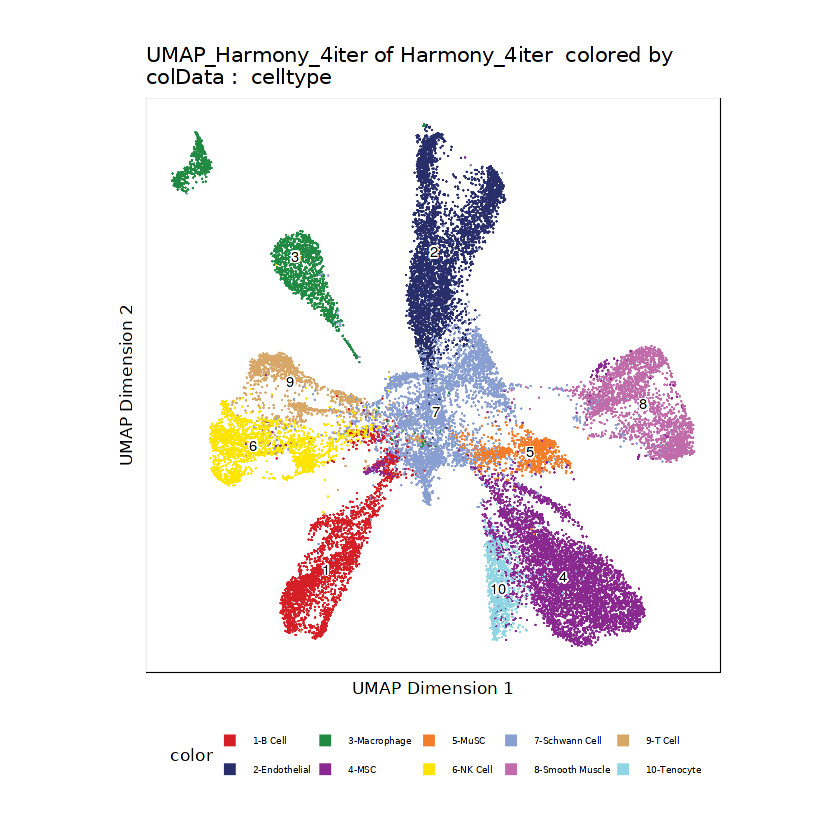

In [10]:
celltype_plt

plotPDF(celltype_plt, 
    name = "Plot-UMAP-celltype-Harmony-4iter.pdf", 
    ArchRProj = projAging4, 
    addDOC = FALSE, width = 4, height = 4)